## __Finance 6470: Derivatives Markets - Guest Lecture by Janette Goodridge__

<br>

* __Using Monte Carlo Simulation to Understand Delta-Hedging__

* Janette Goodridge

* April 22 2019

<br>


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

In [3]:
def plotPricePath(path):
    nsteps = path.shape[0]
    plt.plot(path, 'b', linewidth = 2.5)
    plt.title("Simulated Binomial Price Path")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price ($)")
    plt.xlim((0, nsteps))
    plt.grid(True)
    plt.show()

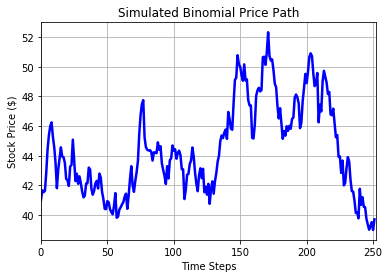

In [4]:
S = 41.0
K = 40.0
v = 0.30
r = 0.08
q = 0.0
T = 1.0
n = 252
mu = (np.log(1.15))/n
h = T / n

path = np.zeros(n)
z = np.random.normal(size=n)
path[0] = S

for t in range(1, n):
    path[t] = path[t-1] * np.exp((r - q - 0.5 * v * v) * h + v * np.sqrt(h) * z[t])
    
plotPricePath(path)

In [5]:
def AssetPaths(spot, mu, sigma, expiry, div, nreps, nsteps):
    paths = np.empty((nreps, nsteps + 1))
    h = expiry / nsteps
    u = np.exp((mu - div) * h + sigma * np.sqrt(h))
    d = np.exp((mu - div) * h - sigma * np.sqrt(h))
    p = (np.exp((mu - div) * h) - d) / (u - d)
    paths[:,0] = spot

    for i in range(nreps):
        w = np.random.uniform(size=nsteps)
        for j in range(nsteps):
            if w[j] >= p: 
                paths[i, j + 1] = paths[i, j] * u
            else:
                paths[i, j + 1] = paths[i, j] * d

    return paths

In [6]:
def AssetPaths(spot, mu, sigma, expiry, div, nreps, nsteps):
    paths = np.empty((nreps, nsteps + 1))
    h = expiry / nsteps
    paths[:, 0] = spot
    mudt = (mu - div - 0.5 * sigma * sigma) * h
    sigmadt = sigma * np.sqrt(h)
    
    for t in range(1, nsteps + 1):
        z = np.random.normal(size=nreps)
        paths[:, t] = paths[:, t-1] * np.exp(mudt + sigmadt * z)

    return paths

In [7]:
paths = AssetPaths(41.0, .00, 0.30, 1.0, 0.0, 10, 253)

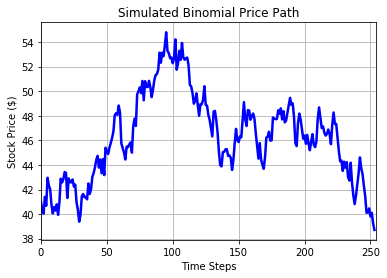

In [8]:
plotPricePath(paths[1])

In [9]:
def bsmCallPrice(S, K, r, v, q, T):
    d1 = (np.log(S/K) + (r - q + 0.5 * v * v) * T) / (v * np.sqrt(T))
    d2 = (np.log(S/K) + (r - q - 0.5 * v * v) * T) / (v * np.sqrt(T))
    callPrc = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return callPrc

def bsmPutPrice(S, K, r, v, q, T):
    d1 = (np.log(S/K) + (r - q + 0.5 * v * v) * T) / (v * np.sqrt(T))
    d2 = (np.log(S/K) + (r - q - 0.5 * v * v) * T) / (v * np.sqrt(T))
    putPrc =  K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    
    return putPrc   

print(f"The BSM Call Price is: {bsmCallPrice(41.0, 40.0, 0.08, 0.30, 0.0, 1.0) : 0.2f}")
print(f"The BSM Put Price is: {bsmPutPrice(41.0, 40.0, 0.08, 0.30, 0.0, 1.0) : 0.2f}")

The BSM Call Price is:  6.96
The BSM Put Price is:  2.89


In [10]:
def callPayoff(spot, strike):
    return np.maximum(spot - strike, 0.0)

S = 41.0
K = 40.0
r = 0.08
v = 0.30
q = 0.0
T = 1.0
m = 100000
n = 252

paths = AssetPaths(S, r, v, T, q, m, n)
callT = callPayoff(paths[:, -1], K)
callPrc = callT.mean()
callPrc *= np.exp(-r * T)
print(f"The Call Price by RNMC is: {callPrc : 0.2f}")

The Call Price by RNMC is:  6.95


In [11]:
def putPayoff(spot, strike):
    return np.maximum(strike - spot, 0.0)

putT = putPayoff(paths[:, -1], K)
putPrc = putT.mean()
putPrc *= np.exp(-r * T)
print(f"The Put Price by RNMC is: {putPrc : 0.2f}")

The Put Price by RNMC is:  2.91


# Stop Loss Strategy

### Let's begin by defining the variables

In [12]:
S = 41
K = 40
n = 252
v = .3
r = .08
mu = (np.log(1.15))/n
q = 0
T = 1
m = 100000

### Now we'll define stop loss, and write the loop, which will map our price path

In [13]:
def stopLoss(S, K, mu, sigma, r, T, paths):
    paths = AssetPaths(S, mu, v, T, 0.0, m, n)
    df = np.exp(-r * np.arange(n) * h)
    covered = False
    costs = np.zeros(m)

    for k in range(m):
        path = paths[k]
        cashFlows = np.zeros(n)
        if path[0] >= K: 
            covered = True
            cashFlows[0] = -path[0]

        for t in range(1, n):
            if covered and (path[t] < K):
                covered = False
                cashFlows[t] = path[t]
            elif not covered and (path[t] > K):
                covered = True
                cashFlows[t] = -path[t]
            else:
                continue

        if (path[-1] >= K):
            cashFlows[-1] = cashFlows[-1] + K

        costs[k] = -np.dot(df, cashFlows)

    return np.mean(costs)

### Now we'll apply our variables to find the stop loss Monte Carlo Price

In [14]:
paths = AssetPaths(S, mu, v, T, q, m, n) # notice that we use mu and not r!
callPrc = stopLoss(S, K, mu, v, r, T, paths)
print(f"The BSM Call Price is: {bsmCallPrice(S, K, r, v, q, T) : 0.4f}")
print(f"The Stop Loss Monte Carlo Price is: {callPrc : 0.4f}")

The BSM Call Price is:  6.9610
The Stop Loss Monte Carlo Price is:  6.7990


# Delta Hedging Strategy
### We'll begin by defining our formula for call delta:

In [15]:
def bsmCallDelta(S, K, r, v, q, tau):
    d1 = (np.log(S/K) + (r - q + 0.5 * v * v) * T) / (v * np.sqrt(T))
    
    return np.exp(-q * T) * norm.cdf(d1)

### Next, we'll write a loop to simulate our delta hedging strategy

In [16]:
def deltaHedging(S, K, mu, sigma, r, T, paths):
    m, n = paths.shape
    cost = np.zeros(m)
    cashFlows = np.zeros(n)
    h = T / n
    df = np.exp(-r * np.arange(n) * h)
    tau = T - np.arange(n) * h
    
    for k in range(m):
        path = paths[k]
        position = 0.0
        deltas = bsmCallDelta(path, K, r, v, q, tau)
        
        for t in range(n):
            cashFlows[t] = (position - deltas[t]) * path[t]
            position = deltas[t]
            
        if (path[-1] >= K):
            cashFlows[-1] = K - (1 - position) * path[-1]
        else:
            cashFlows[-1] = position * path[-1]
        
        cost[k] = -np.dot(df, cashFlows)
        
    return np.mean(cost)

### Apply the call price using delta hedging

In [17]:
paths = AssetPaths(S, mu, v, T, q, m, n)
delHdgPrc = deltaHedging(S, K, mu, v, r, T, paths)
bsmPrc = bsmCallPrice(S, K, r, v, q, T)
print(f"The BSM Call Price is: {bsmPrc : 0.4f}")
print(f"The Delta-Hedging Monte Carlo Call Price is: {delHdgPrc : 0.4f}")

The BSM Call Price is:  6.9610
The Delta-Hedging Monte Carlo Call Price is:  7.0787


# Simulating jumps with Poisson Distribution

### Let's begin the simulation by defining our variables consistent with figure 19.7 from McDonald.

In [18]:
spot=41
v=.3
T=1
n=252
m=3
q=0
alpha=.09
lamda=3
a_j= -.02
v_j=.05
k=np.exp(a_j)-1

### Next, we will define the plots in order to graph our simulation, first without jumps then with jumps.

In [19]:
def plotPricePath(path):
    nsteps = path.shape[0]
    plt.plot(path, 'b', linewidth = 1.5)
    plt.title("Simulated Price Path")
    plt.xlabel("Days")
    plt.ylabel("Stock Price ($)")
    plt.xlim((0, nsteps))
    plt.grid(True)
    plt.show()
    
def plotwithjumps(pathj):
    nsteps = pathj.shape[0]
    plt.plot(pathj, 'b', linewidth = 2.5)
    plt.title("Simulated Price Path with Jumps")
    plt.xlabel("Days")
    plt.ylabel("Stock Price ($)")
    plt.xlim((0, nsteps))
    plt.grid(True)
    plt.show()

Now we will simulate the 2 paths using a loop. First we will select a random normal variable (Z). Next, we select m from the Poisson distribution, which just indicates the probability of a given number of events occuring in a fixed period of time. In this case, the event would be jumps, meaning that m would be the number of jumps.

<br>

Last, we select m draws, w, from the standard normal distribtion. Notice that we are also summing up the w's (see equation 19.16 from McDonald)

In [20]:
path = np.zeros(n)
pathj = np.zeros(n)
h= T/n

mu_h = (alpha - q - 0.5 * v * v) * h
sigma_h = v * np.sqrt(h)
path[0] = spot
pathj[0] = spot

z1 = np.random.normal(size=n)
z2 = np.random.normal(size=n)

for t in range(1, n):
    m = np.random.poisson(lam=lamda*h, size=1)
    w = np.random.normal(size=m)
    path[t] = path[t-1] * np.exp(mu_h + sigma_h * z1[t])
    theta1 = (alpha - q - lamda * k -0.5 * v * v)* h + v * np.sqrt(h) * z1[t]
    theta2 = m * (a_j - 0.5 * v_j * v_j) + v_j * np.sum(w)
    path[t] = path[t-1] * np.exp(theta1)
    pathj[t] = pathj[t-1] * np.exp(theta1) * np.exp(theta2)

df = pd.DataFrame({'GBM' : path, 'Jumps' : pathj})        

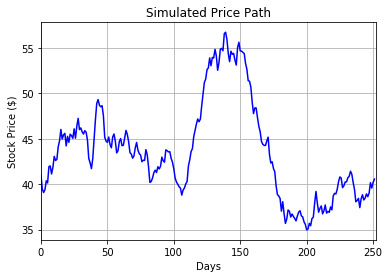

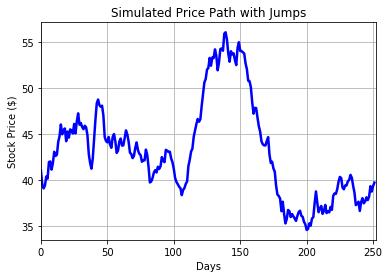

In [21]:
plotPricePath(path)
plotwithjumps(pathj)

In [22]:
w

array([], dtype=float64)

### Now we'll put them together on the same graph

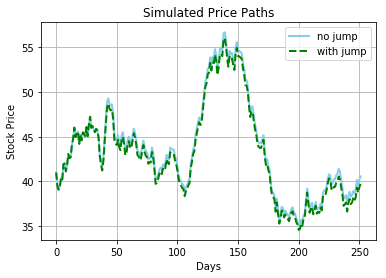

In [23]:
plt.plot( 'GBM', data=df, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2, label="no jump")
plt.plot( 'Jumps', data=df, marker='', color='green', linewidth=2, linestyle='dashed', label="with jump")
plt.title("Simulated Price Paths")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.grid(True)
plt.legend()


In [24]:
tmp = df.GBM.values - df.Jumps.values

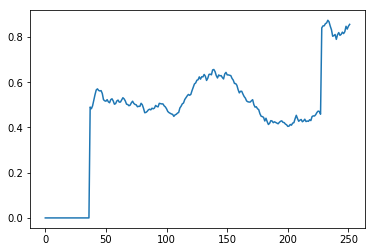

In [25]:
plt.plot(tmp)

In [26]:
plt.show()